<center>IE 7300: Statistical Learning for Engineering</center>
<center>HW 10</center>
<center>Youyu Zhang</center>
<center>zhang.youy@northeastern.edu</center>
<center>(530)574-2826</center>
<center>Code available on: https://github.com/kuohu233/IE_7300</center>
<center>Submitted by 12/6/2022</center>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#### 1. Compare your model performance with different numbers of hidden nodes

In [3]:
# Import dataset. Critical temperature unit: K
dataset = pd.read_csv('train.csv')       # Main feature dataset
formula = pd.read_csv('unique_m.csv')    # Formula of materials.

In [78]:
x = dataset.iloc[:,0:dataset.shape[1]-1]
y = dataset["critical_temp"].values.reshape(x.shape[0], 1)
y_true = dataset["critical_temp"]
x.shape

(21263, 81)

Split data and standarization.

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#split data into train and test set
Xtrain, Xtest, ytrain, ytest, ytrue_train, ytrue_test = train_test_split(np.array(x), np.array(y), y_true, test_size=0.2, random_state=2)

In [80]:
sc = StandardScaler()
sc.fit(Xtrain)
Xtrain = sc.transform(Xtrain)
Xtest = sc.transform(Xtest)

print(f"Shape of train set is {Xtrain.shape}")
print(f"Shape of test set is {Xtest.shape}")
print(f"Shape of train label is {ytrain.shape}")
print(f"Shape of test labels is {ytest.shape}")

Shape of train set is (17010, 81)
Shape of test set is (4253, 81)
Shape of train label is (17010, 1)
Shape of test labels is (4253, 1)


In [269]:
class NeuralNet():
    '''
    A two layer neural network
    '''
        
    def __init__(self, layers=[13,8,1], learning_rate=0.001, iterations=100):
        self.params = {}
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.loss = []
        self.sample_size = None
        self.layers = layers
        self.X = None
        self.y = None
                
    def init_weights(self):
        '''
        Initialize the weights from a random normal distribution
        '''
        np.random.seed(1) # Seed the random number generator
        for i in range(len(self.layers)-1):
            ws = "W"+str(i+1)
            bs = "b"+str(i+1)
            self.params[ws] = np.random.randn(self.layers[i], self.layers[i+1]) 
            self.params[bs] =np.random.randn(self.layers[i+1],)
        # self.params["W1"] = np.random.randn(self.layers[0], self.layers[1]) 
        # self.params['b1']  =np.random.randn(self.layers[1],)
        # self.params['W2'] = np.random.randn(self.layers[1],self.layers[2]) 
        # self.params['b2'] = np.random.randn(self.layers[2],)
    
    def relu(self,Z):
        '''
        The ReLu activation function is to performs a threshold
        operation to each input element where values less 
        than zero are set to zero.
        '''
        return np.maximum(0,Z)

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def eta(self, x):
      ETA = 0.0000000001
      return np.maximum(x, ETA)

    def tanh(self, Z):
        # t=(np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
        t = np.tanh(Z)
        return t

    def dtanh(self, Z):
        t=(np.exp(Z)-np.exp(-Z))/(np.exp(Z)+np.exp(-Z))
        dt=1-t**2
        return dt

    def linear(self, Z):
        return Z
    
    def dlinear(self, Z):
        return 1

    def sigmoid(self,Z):
        '''
        The sigmoid function takes in real numbers in any range and 
        squashes it to a real-valued output between 0 and 1.
        '''
        return 1/(1+np.exp(-Z))

    def entropy_loss(self,y, yhat):
        nsample = len(y)
        yhat_inv = 1.0 - yhat
        y_inv = 1.0 - y
        yhat = self.eta(yhat) ## clips value to avoid NaNs in log
        yhat_inv = self.eta(yhat_inv) 
        loss = -1/nsample * (np.sum(np.multiply(np.log(yhat), y) + np.multiply((y_inv), np.log(yhat_inv))))
        return loss

    def forward_propagation(self):
        '''
        Performs the forward propagation
        '''
        # print(f"self params shape:{self.params['W1']}")
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.sigmoid(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def forward_propagation2(self):
        '''
        Performs the forward propagation
        '''
        # print(f"self params shape:{self.params['W1']}")
        Z1 = self.X.dot(self.params['W1']) + self.params['b1']
        A1 = self.tanh(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        yhat = self.linear(Z2)
        loss = self.entropy_loss(self.y,yhat)

        # save calculated parameters     
        self.params['Z1'] = Z1
        self.params['Z2'] = Z2
        self.params['A1'] = A1

        return yhat,loss

    def back_propagation(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * dl_wrt_sig

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dRelu(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def back_propagation2(self,yhat):
        '''
        Computes the derivatives and update weights and bias according.
        '''
        y_inv = 1 - self.y
        yhat_inv = 1 - yhat

        dl_wrt_yhat = np.divide(y_inv, self.eta(yhat_inv)) - np.divide(self.y, self.eta(yhat))
        dl_wrt_sig = yhat * (yhat_inv)
        dl_wrt_z2 = dl_wrt_yhat * 1

        dl_wrt_A1 = dl_wrt_z2.dot(self.params['W2'].T)
        dl_wrt_w2 = self.params['A1'].T.dot(dl_wrt_z2)
        dl_wrt_b2 = np.sum(dl_wrt_z2, axis=0, keepdims=True)

        dl_wrt_z1 = dl_wrt_A1 * self.dtanh(self.params['Z1'])
        dl_wrt_w1 = self.X.T.dot(dl_wrt_z1)
        dl_wrt_b1 = np.sum(dl_wrt_z1, axis=0, keepdims=True)

        #update the weights and bias
        self.params['W1'] = self.params['W1'] - self.learning_rate * dl_wrt_w1
        self.params['W2'] = self.params['W2'] - self.learning_rate * dl_wrt_w2
        self.params['b1'] = self.params['b1'] - self.learning_rate * dl_wrt_b1
        self.params['b2'] = self.params['b2'] - self.learning_rate * dl_wrt_b2

    def fit(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation()
            self.back_propagation(yhat)
            self.loss.append(loss)

    def fit2(self, X, y):
        '''
        Trains the neural network using the specified data and labels
        '''
        self.X = X
        self.y = y
        self.init_weights() #initialize weights and bias


        for i in range(self.iterations):
            yhat, loss = self.forward_propagation2()
            # self.back_propagation2(yhat)
            self.loss.append(loss)

    def predict(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.relu(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.sigmoid(Z2)
        return np.round(pred) 

    def predict2(self, X):
        '''
        Predicts on a test data
        '''
        Z1 = X.dot(self.params['W1']) + self.params['b1']
        A1 = self.tanh(Z1)
        Z2 = A1.dot(self.params['W2']) + self.params['b2']
        pred = self.linear(Z2)
        return np.round(pred) 

    def acc(self, y, yhat):
        '''
        Calculates the accuracy between the predicted values and actual
        '''
        acc = int(sum(y == yhat) / len(y) * 100)
        return acc


    def plot_loss(self):
        '''
        Plots the loss curve
        '''
        plt.plot(self.loss)
        plt.xlabel("Iteration")
        plt.ylabel("logloss")
        plt.title("Loss curve for training")
        plt.show()  

In [281]:
nn1 = NeuralNet(layers=[Xtrain.shape[1], 10, 1],
     learning_rate=0.001, iterations=100) # create the NN model
nn1.fit(Xtrain, ytrain) #train the model

C:\Users\youyu\AppData\Local\Temp/ipykernel_31640/2579518989.py:69: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-Z))


In [111]:
train_pred1 = nn1.predict(Xtrain)
test_pred1 = nn1.predict(Xtest)

print("Train accuracy is {}".format(nn1.acc(ytrain, train_pred1)))
print("Test accuracy is {}".format(nn1.acc(ytest, test_pred1)))

Train accuracy is 0
Test accuracy is 0


C:\Users\youyu\AppData\Local\Temp/ipykernel_31640/1925195097.py:61: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-Z))


In [92]:
cost_train1 = (ytrain-train_pred1)**2
prediction_train1 = pd.DataFrame({"Y": ytrue_train, 
    "Y_predict": train_pred1.reshape(train_pred1.shape[0]),
    "cost":cost_train1.reshape(cost_train1.shape[0])})
prediction_train1

,Y,Y_predict,cost
11065,0.50,1.0,0.2500
5689,40.00,1.0,1521.0000
2176,84.00,1.0,6889.0000
9595,32.20,1.0,973.4400
9034,78.10,1.0,5944.4100
...,...,...,...
1099,92.50,1.0,8372.2500
18898,17.10,1.0,259.2100
11798,0.21,1.0,0.6241
6637,88.40,1.0,7638.7600


In [282]:
rmse_train1 = np.sqrt(sum(cost_train1)/len(cost_train1))
r2_train1= 1-sum(cost_train1)/sum((np.array(train_pred1.reshape(train_pred1.shape[0]))-sum(np.array(train_pred1.reshape(train_pred1.shape[0])))/len(np.array(train_pred1)))**2)

print(f'RMSE of NN on training dataset = {round(rmse_train1[0],3)}')
print(f'R2 score = {round(r2_train1[0],3)}')

RMSE of NN on training dataset = 47.995
R2 score = -inf


C:\Users\youyu\AppData\Local\Temp/ipykernel_31640/2353467826.py:2: RuntimeWarning: divide by zero encountered in true_divide
  r2_train1= 1-sum(cost_train1)/sum((np.array(train_pred1.reshape(train_pred1.shape[0]))-sum(np.array(train_pred1.reshape(train_pred1.shape[0])))/len(np.array(train_pred1.reshape(train_pred1.shape[0]))))**2)


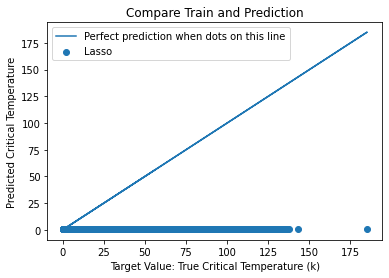

In [94]:
plt.scatter(prediction_train1['Y'], prediction_train1['Y_predict'], label='True')
plt.plot(prediction_train1['Y'], prediction_train1['Y'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Compare Train and Prediction')
plt.xlabel('Target Value: True Critical Temperature (k)')
plt.ylabel('Predicted Critical Temperature')
plt.show()

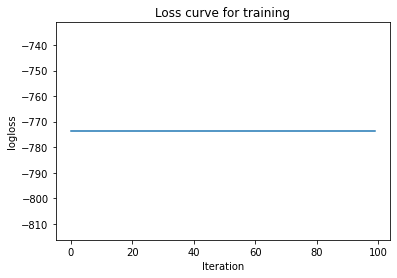

In [102]:
nn2 = NeuralNet(layers=[Xtrain.shape[1], 5, 1],
     learning_rate=0.001, iterations=100) # create the NN model
nn2.fit(Xtrain, ytrain) #train the model
nn2.plot_loss()

In [118]:
train_pred2 = nn2.predict(Xtrain)
test_pred2 = nn2.predict(Xtest)

print("Train accuracy is {}".format(nn2.acc(ytrain, train_pred2)))
print("Test accuracy is {}".format(nn2.acc(ytest, test_pred2)))

Train accuracy is 0
Test accuracy is 0


In [293]:
cost_train2 = (ytrain-train_pred2)**2
rmse_train2 = np.sqrt(sum(cost_train2)/len(cost_train2))
r2_train2= 1-sum(cost_train2)/sum((np.array(train_pred2.reshape(train_pred2.shape[0]))-sum(np.array(train_pred2.reshape(train_pred2.shape[0])))/len(np.array(train_pred2)))**2)

print(f'RMSE of NN on training dataset = {round(rmse_train2[0],3)}')
print(f'R2 score = {round(r2_train2[0],3)}')

RMSE of NN on training dataset = 47.995
R2 score = -inf


C:\Users\youyu\AppData\Local\Temp/ipykernel_31640/1011046090.py:3: RuntimeWarning: divide by zero encountered in true_divide
  r2_train2= 1-sum(cost_train2)/sum((np.array(train_pred2.reshape(train_pred2.shape[0]))-sum(np.array(train_pred2.reshape(train_pred2.shape[0])))/len(np.array(train_pred2)))**2)


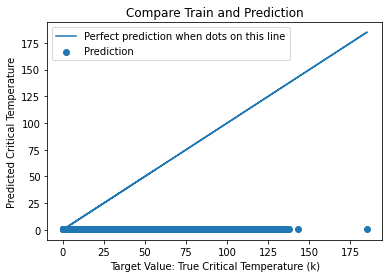

In [276]:
cost_train2 = (ytrain-train_pred2)**2
prediction_train2 = pd.DataFrame({"Y": ytrue_train, 
    "Y_predict": train_pred2.reshape(train_pred2.shape[0]),
    "cost":cost_train2.reshape(cost_train2.shape[0])})

plt.scatter(prediction_train2['Y'], prediction_train2['Y_predict'], label='Prediction')
plt.plot(prediction_train2['Y'], prediction_train2['Y'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Compare Train and Prediction')
plt.xlabel('Target Value: True Critical Temperature (k)')
plt.ylabel('Predicted Critical Temperature')
plt.show()

The NNs above use 1 hidden layer with 10 and 5 nodes between. The first activation function is ReLU and the second one is sigmoid function. With the current project data cleaning process and modeling, the outcome accuracy is 0. The activation functions did not work in this example. The prediction accuracy and the RMSE, R2 score did not fit the data at all.  All the prediction values are 0, which is not the prediction value should be. 

At this time, we can conclude that the neural network with ReLU and sigmoid functions are not ideal for critical temperature prediction in this case. 

#### 2. Show the model performance with two different activation functions

This part will use tanh and linear activation function to fit and predict.

In [270]:
nn3 = NeuralNet(layers=[Xtrain.shape[1], 5, 1],
     learning_rate=0.001, iterations=100) # create the NN model
nn3.fit2(Xtrain, ytrain) #train the model

In [271]:
train_pred3 = nn3.predict2(Xtrain)
test_pred3 = nn3.predict2(Xtest)

print("Train accuracy is {}".format(nn1.acc(ytrain, train_pred3)))
print("Test accuracy is {}".format(nn1.acc(ytest, test_pred3)))

Train accuracy is 0
Test accuracy is 0


In [273]:
cost_train3 = (ytrain-train_pred3)**2
rmse_train3 = np.sqrt(sum(cost_train3)/len(cost_train3))
r2_train3= 1-sum(cost_train3)/sum((np.array(train_pred3.reshape(train_pred3.shape[0]))-sum(np.array(train_pred3.reshape(train_pred3.shape[0])))/len(np.array(train_pred3.reshape(train_pred3.shape[0]))))**2)

print(f'RMSE of tanh&linear model on training dataset = {round(rmse_train3[0],3)}')
print(f'R2 score = {round(r2_train3[0],3)}')

RMSE of tanh&linear model on training dataset = 45.302
R2 score = -8648.547


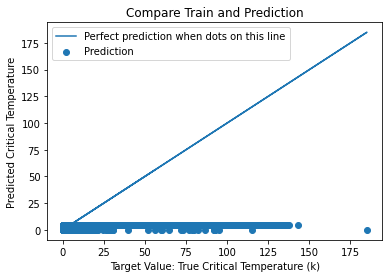

In [278]:
prediction_train3 = pd.DataFrame({"Y": ytrue_train, 
    "Y_predict": train_pred3.reshape(train_pred3.shape[0]),
    "cost":cost_train3.reshape(cost_train3.shape[0])})

plt.scatter(prediction_train3['Y'], prediction_train3['Y_predict'], label='Prediction')
plt.plot(prediction_train3['Y'], prediction_train3['Y'], label='Perfect prediction when dots on this line')
plt.legend(loc="upper left")
plt.title('Compare Train and Prediction')
plt.xlabel('Target Value: True Critical Temperature (k)')
plt.ylabel('Predicted Critical Temperature')
plt.show()

In [283]:
prediction_train3

,Y,Y_predict,cost
11065,0.50,5.0,20.2500
5689,40.00,5.0,1225.0000
2176,84.00,5.0,6241.0000
9595,32.20,5.0,739.8400
9034,78.10,5.0,5343.6100
...,...,...,...
1099,92.50,5.0,7656.2500
18898,17.10,5.0,146.4100
11798,0.21,5.0,22.9441
6637,88.40,5.0,6955.5600


The prediction does not look good. The prediction maximum is obviously lower than most of the true values. R2 score indicated that the prediction did not correspond to the trend of true values. The tanh activation function would predict all the observations into similar values. The back_propagation part does not work well on the process. 

Overall, this model did not able to find the pattern of the dataset.

#### 3. Show your output with Stochastic gradient and gradient optimization methods.

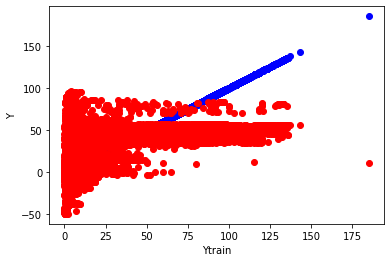

theta: [ 4.28373448e-06  4.58476446e-05  2.55660243e-05  3.46612158e-05
  1.71958529e-05  1.14855344e-06  1.18682683e-06  9.83444301e-05
 -1.76314887e-06  3.06157297e-05  2.68670590e-05  4.85161081e-04
  6.39253830e-04  4.46486677e-04  5.87097899e-04  1.21698200e-06
  8.03429365e-07  6.90900047e-04  4.24039681e-04  2.34856291e-04
  2.68552870e-04  1.10509265e-04  7.68704186e-05  9.18817539e-05
  5.71719086e-05  1.18826832e-06  1.16217412e-06  1.71316164e-04
  1.16104343e-05  5.52631860e-05  5.93801947e-05  9.21426742e-04
  2.46493217e-04 -1.61890761e-03 -1.81532933e-03  1.04654406e-06
  7.74071086e-07  3.03312402e-03  4.12477654e-05  5.64908566e-04
  1.00955934e-03  2.86184189e-05  5.72653985e-05  4.11645611e-06
  3.05874224e-05  9.15476827e-07  5.50913574e-07  9.28117990e-05
  4.24727152e-05  3.69192053e-05  3.59176700e-05 -3.73149518e-07
 -2.50373399e-06 -2.41806502e-06 -4.32845394e-06  1.12292261e-06
  9.75433869e-07  3.58727204e-06 -1.68232058e-06  1.85843930e-07
  2.12395306e-07  

In [161]:
# Define the model parameters
learning_rate = 5e-11
num_epochs = 1000

# Initialize the model coefficients
theta = np.zeros(Xtrain.shape[1])

# Define the SGD model
def model(X, theta):
  return X @ theta

# Define the loss function
def loss(X, y, theta_0, theta_1):
  return 1 / len(X) * sum((model(X, theta_0, theta_1) - y) ** 2)

# Define the gradient descent step
def step(X, y, theta, learning_rate):
  gradients = 2 / len(X) * X.T @ (model(X, theta) - y)
  theta -= learning_rate * gradients
  return theta

# Perform gradient descent
for epoch in range(num_epochs):
    theta= step(Xtrain, ytrain.reshape(ytrain.shape[0]), theta, learning_rate)

# Plot the data and the model predictions
plt.scatter(ytrain.reshape(ytrain.shape[0]),
    ytrain.reshape(ytrain.shape[0]),
    color='blue')
plt.scatter(ytrain.reshape(ytrain.shape[0]), model(Xtrain, theta), color='red')
plt.xlabel('Ytrain')
plt.ylabel('Y')
plt.show()

# Print coefs
print('theta:', theta)

In [189]:
train_pred4 = model(Xtrain, theta)
test_pred4 = model(Xtest, theta)

cost_train4 = (ytrain.reshape(ytrain.shape[0])-train_pred4)**2
rmse_train4 = np.sqrt(sum(cost_train4)/len(cost_train4))
r2_train4= 1-sum(cost_train4)/sum((np.array(train_pred4)-sum(np.array(train_pred4))/len(np.array(train_pred4)))**2)

print(f'RMSE of stochastic gradient model on training dataset = {round(rmse_train4,3)}')
print(f'R2 score = {round(r2_train4,3)}')

RMSE of stochastic gradient model on training dataset = 30.897
R2 score = -1.209


The RMSE means that the cost of the prediction is not high, but R2 score indicated that the prediction values are not corresponding to the true patterns.The distribution of predicted values indicated that the model catched the target values' feature, but failed to find the relationships between X and Y. This could occured especially when X has too many columns while the most correlated features were not emphasized. 